# Importing Necessary Libraries

In [1]:
# Importing Necessary Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import re
import warnings
warnings.filterwarnings('ignore')

# Load the data

In [2]:
# Load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Data Preprocessing

In [3]:
# Data Preprocessing
X = train_df.drop(columns=['label'])
y = train_df['label']
test = test_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
def tokenize_and_clean(text):
    lowered = text.lower()
    cleaned = re.sub('@user', '', lowered)
    tokens = word_tokenize(cleaned)
    filtered_tokens = [token for token in tokens if re.match(r'\w{1,}', token)]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(token) for token in filtered_tokens]
    return stems

# TF-IDF Vectorization

In [5]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_and_clean, stop_words='english')
X_train_tweets_tfidf = tfidf_vectorizer.fit_transform(X_train['tweet'])
X_test_tweets_tfidf = tfidf_vectorizer.transform(X_test['tweet'])
X_tweets_tfidf = tfidf_vectorizer.fit_transform(X['tweet'])
test_tweets_tfidf = tfidf_vectorizer.transform(test['tweet'])

# Check Class Imbalance Before & After SMOTE

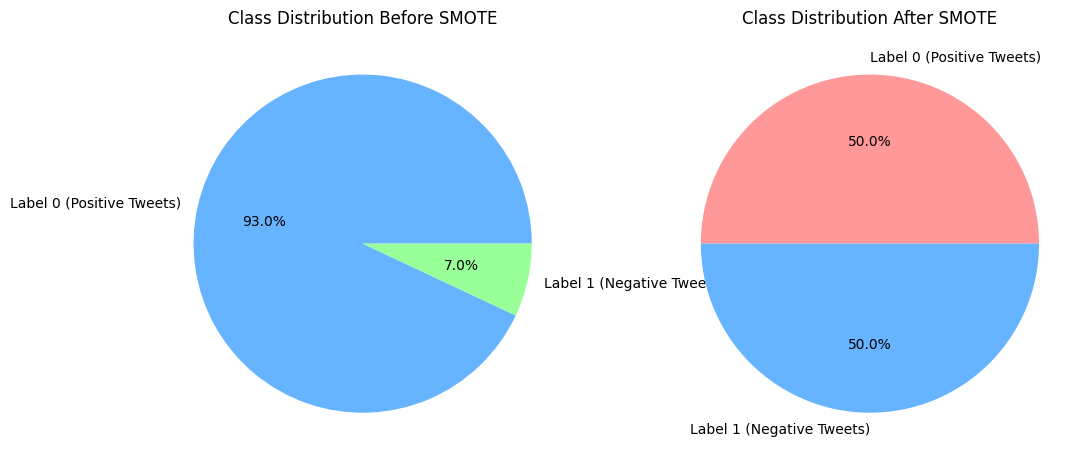

In [6]:
# Class Imbalance Check Before SMOTE
plt.figure(figsize=(12, 6))

colors_before_smote = ['#66b3ff', '#99ff99']
colors_after_smote = ['#ff9999', '#66b3ff']

labels = ['Label 0 (Positive Tweets)', 'Label 1 (Negative Tweets)']

plt.subplot(1, 2, 1)
plt.pie(y_train.value_counts(), labels=labels, autopct='%0.1f%%', colors=colors_before_smote)
plt.title('Class Distribution Before SMOTE')

smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_tweets_tfidf, y_train.values)

plt.subplot(1, 2, 2)
plt.pie(pd.value_counts(y_train_smote), labels=labels, autopct='%0.1f%%', colors=colors_after_smote)
plt.title('Class Distribution After SMOTE')
plt.show()

# Machine Learning Modeling

#  Model Evaluation


Evaluating Logistic Regression...

Model: LogisticRegression
Training Scores:
Training Scores: Accuracy=0.935, F1-Score=0.937
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     23783
           1       0.92      0.96      0.94     23783

    accuracy                           0.94     47566
   macro avg       0.94      0.94      0.94     47566
weighted avg       0.94      0.94      0.94     47566

Validating Scores:
Validating Scores: Accuracy=0.904, F1-Score=0.555
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      5937
           1       0.42      0.84      0.56       456

    accuracy                           0.90      6393
   macro avg       0.70      0.87      0.75      6393
weighted avg       0.95      0.90      0.92      6393


Evaluating Multinomial NB...

Model: MultinomialNB
Training Scores:
Training Scores: Accuracy=0.966, F1-Score=0.967
              precision    recall

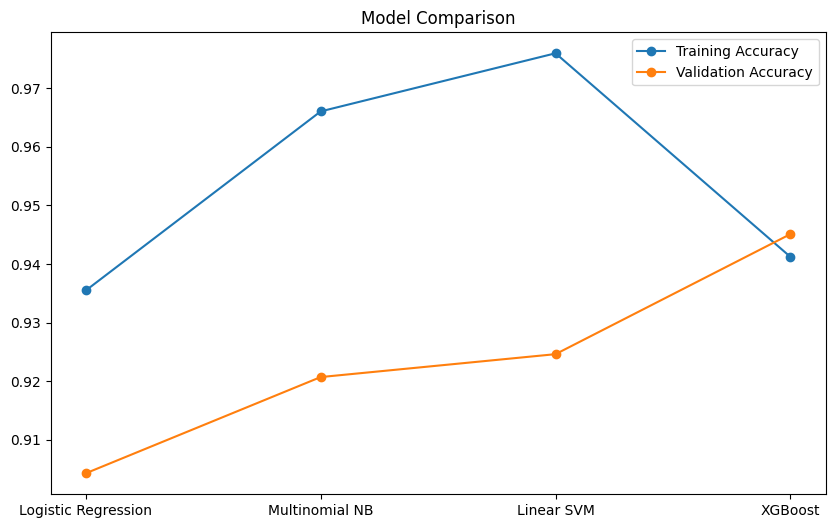

In [12]:
def training_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Training Scores: Accuracy={acc}, F1-Score={f1}')
    print(classification_report(y_act, y_pred))

def validating_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Validating Scores: Accuracy={acc}, F1-Score={f1}')
    print(classification_report(y_act, y_pred))

# Machine Learning Modeling
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f'\nModel: {model.__class__.__name__}')
    print("Training Scores:")
    training_scores(y_train, y_train_pred)  # Ensure training_scores is correctly called
    print("Validating Scores:")
    validating_scores(y_test, y_test_pred)  # Ensure validation_scores is correctly called
    
    return y_test_pred
#  Model Evaluation
models = {
    "Logistic Regression": LogisticRegression(penalty='l2', C=0.1),
    "Multinomial NB": MultinomialNB(),
    "Linear SVM": LinearSVC(C=0.1),
    "XGBoost": XGBClassifier(objective='binary:logistic', eval_metric='logloss')
}

train_scores = []
validation_scores = []

for name, model in models.items():
    print(f'\nEvaluating {name}...')
    y_test_pred = train_and_evaluate(model, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)
    
    train_acc = accuracy_score(y_train_smote, model.predict(X_train_smote))
    val_acc = accuracy_score(y_test, y_test_pred)
    
    train_scores.append(train_acc)
    validation_scores.append(val_acc)

plt.figure(figsize=(10, 6))
plt.plot(models.keys(), train_scores, label='Training Accuracy', marker='o')
plt.plot(models.keys(), validation_scores, label='Validation Accuracy', marker='o')
plt.legend()
plt.title('Model Comparison')
plt.show()

# Hyperparameter Tuning

In [13]:
# Hyperparameter Tuning
# Logistic Regression
lr_tuned = LogisticRegression(penalty='l2', C=0.01)
train_and_evaluate(lr_tuned, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

# SVM Tuning 
svm_tuned = LinearSVC(C=0.1)
train_and_evaluate(svm_tuned, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)

# XGBoost
xgb_tuned = XGBClassifier(objective='binary:logistic', eval_metric='logloss',
                          learning_rate=0.1, max_depth=5, gamma=0.1,
                          reg_lambda=1.0, reg_alpha=0.5)  # Adjust regularization parameters

train_and_evaluate(xgb_tuned, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)


Model: LogisticRegression
Training Scores:
Training Scores: Accuracy=0.881, F1-Score=0.877
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     23783
           1       0.91      0.84      0.88     23783

    accuracy                           0.88     47566
   macro avg       0.88      0.88      0.88     47566
weighted avg       0.88      0.88      0.88     47566

Validating Scores:
Validating Scores: Accuracy=0.907, F1-Score=0.553
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      5937
           1       0.42      0.80      0.55       456

    accuracy                           0.91      6393
   macro avg       0.70      0.86      0.75      6393
weighted avg       0.94      0.91      0.92      6393


Model: LinearSVC
Training Scores:
Training Scores: Accuracy=0.976, F1-Score=0.976
              precision    recall  f1-score   support

           0       0.99      0.96      0.98    

array([0, 0, 0, ..., 0, 0, 0])

# Evaluate Tuned Models


Evaluating Logistic Regression Tuned...

Model: LogisticRegression
Training Scores:
Training Scores: Accuracy=0.881, F1-Score=0.877
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     23783
           1       0.91      0.84      0.88     23783

    accuracy                           0.88     47566
   macro avg       0.88      0.88      0.88     47566
weighted avg       0.88      0.88      0.88     47566

Validating Scores:
Validating Scores: Accuracy=0.907, F1-Score=0.553
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      5937
           1       0.42      0.80      0.55       456

    accuracy                           0.91      6393
   macro avg       0.70      0.86      0.75      6393
weighted avg       0.94      0.91      0.92      6393


Evaluating SVM Tuned...

Model: LinearSVC
Training Scores:
Training Scores: Accuracy=0.976, F1-Score=0.976
              precision    recall  f

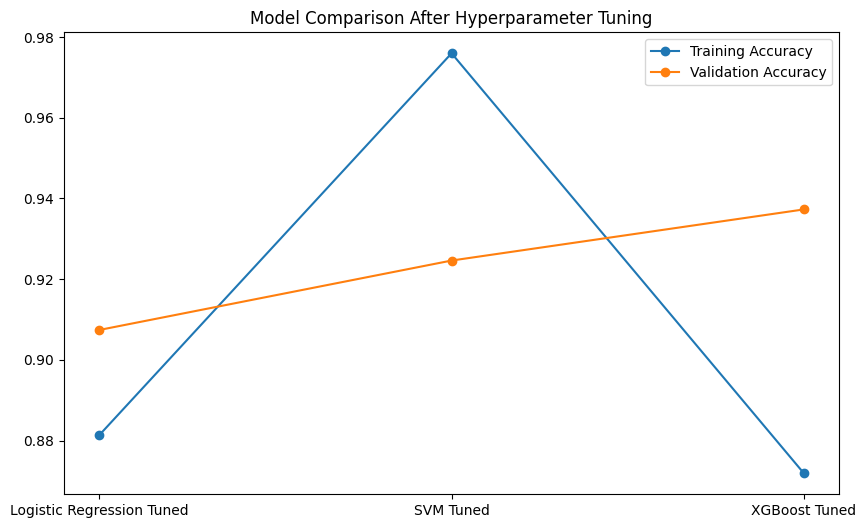

In [14]:
# Evaluate Tuned Models
tuned_models = {
    "Logistic Regression Tuned": lr_tuned,
    "SVM Tuned": svm_tuned,
    "XGBoost Tuned": xgb_tuned
}

tuned_train_scores = []
tuned_validation_scores = []

for name, model in tuned_models.items():
    print(f'\nEvaluating {name}...')
    y_test_pred = train_and_evaluate(model, X_train_smote, y_train_smote, X_test_tweets_tfidf, y_test)
    
    train_acc = accuracy_score(y_train_smote, model.predict(X_train_smote))
    val_acc = accuracy_score(y_test, y_test_pred)
    
    tuned_train_scores.append(train_acc)
    tuned_validation_scores.append(val_acc)

plt.figure(figsize=(10, 6))
plt.plot(tuned_models.keys(), tuned_train_scores, label='Training Accuracy', marker='o')
plt.plot(tuned_models.keys(), tuned_validation_scores, label='Validation Accuracy', marker='o')
plt.legend()
plt.title('Model Comparison After Hyperparameter Tuning')
plt.show()